# FCA analysis - annotate clusters and identify DEGs

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import glob
import matplotlib.pyplot as pl

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_manual_annotation/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8

'/opt/conda/bin/python'

## Load data

In [2]:
adata = sc.read('FCA-M3clusters.h5ad')
adata.X.shape

(319081, 28037)

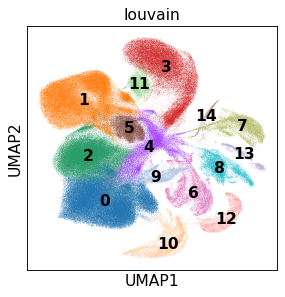

In [3]:
sc.pl.umap(adata, color='louvain',legend_loc='on data',save='_clustering_clusnumbers.pdf')

In [5]:
sc.pl.umap(adata, color=['louvain', 'PCW', 'process'], legend_loc='on data')

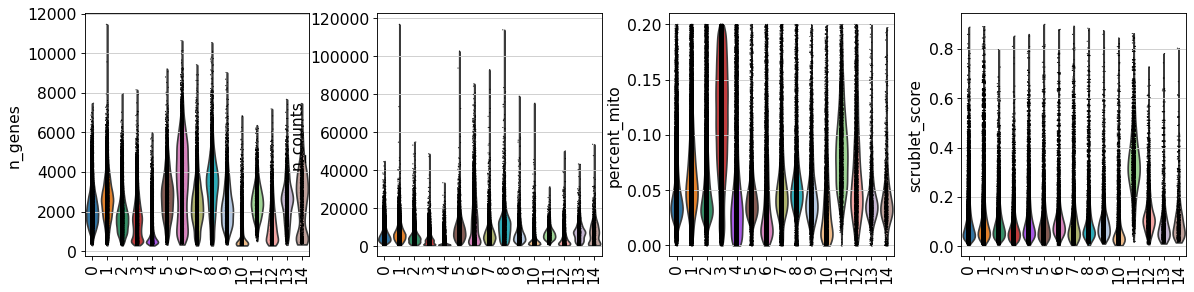

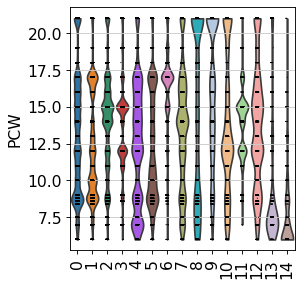

In [6]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'scrublet_score'], groupby = 'louvain', rotation = 90)
sc.pl.violin(adata, ['PCW'], groupby = 'louvain', rotation = 90)

In [7]:
# sc.pl.umap(adata, color=['MSC', 'NR2F1', 'WT1', 'TCF21', 'DLK1', 'PENK', 'RGS5', 'CYSTM1', 'HSD3B2', 'MAFB', 'GATA3', 'ARX', 'NR0B1', 'ACTA2', 'MYH11'], color_map='OrRd', use_raw=False)

In [8]:
def Barplot(which_var, adata, var='clusters_manual', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index = plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

The lists are not identical


... storing 'old_clustres' as categorical


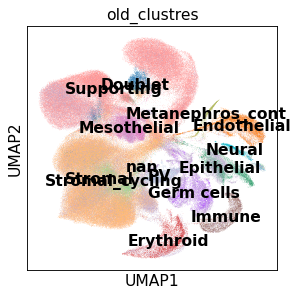

In [9]:
# Add cluster name and doublet information
clu_annot = pd.read_csv('../scRNAseq_analysis_FCA_2sex/figures_manual_annotation/clustering_metadata.csv', header=0, index_col=0)
import collections 

if collections.Counter(adata.obs.index) == collections.Counter(clu_annot.index): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 
    
adata.obs['old_clustres'] = clu_annot['clusters']

sc.pl.umap(adata, color='old_clustres', legend_loc='on data')

<ipython-input-8-5894830891c8>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',


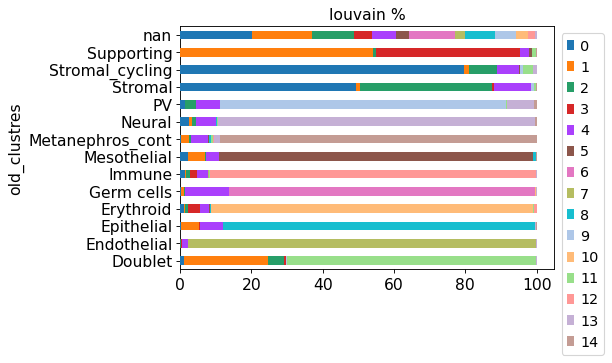

In [10]:
Barplot('louvain', adata, var='old_clustres', height=4)

In [11]:
marker_genes = {
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'GCs': {'DAZL', 'DDX4'}, 
    'Mesothelial': {'LRRN4', 'LHX2', 'KLK11'},
    'Supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'preGranulosa':{"KITLG", 'FOXL2'},
    'Sertoli': {'SOX9', 'AMH', 'INHA'},
    'Mesenchymal':{'DCN', 'PDGFRA', 'COL1A1'},
    'gonadal':{'GATA4', 'LHX9', 'ARX'},
    'extragonadal':{'GATA2', 'NR2F1'},
    'PV': {"PDGFRB", 'ACTA2'},
    'Immune': {'PTPRC'},
    'Endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'Epithelial': {"EPCAM", 'PAX8'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Erythroid': {"GYPC", "HBA1"},
    'Neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'},
    'Erythroid': {"GYPC", "HBA1"},
    'Metanephros': {"NPHS2", "CLIC5", "PTPRO"}
}

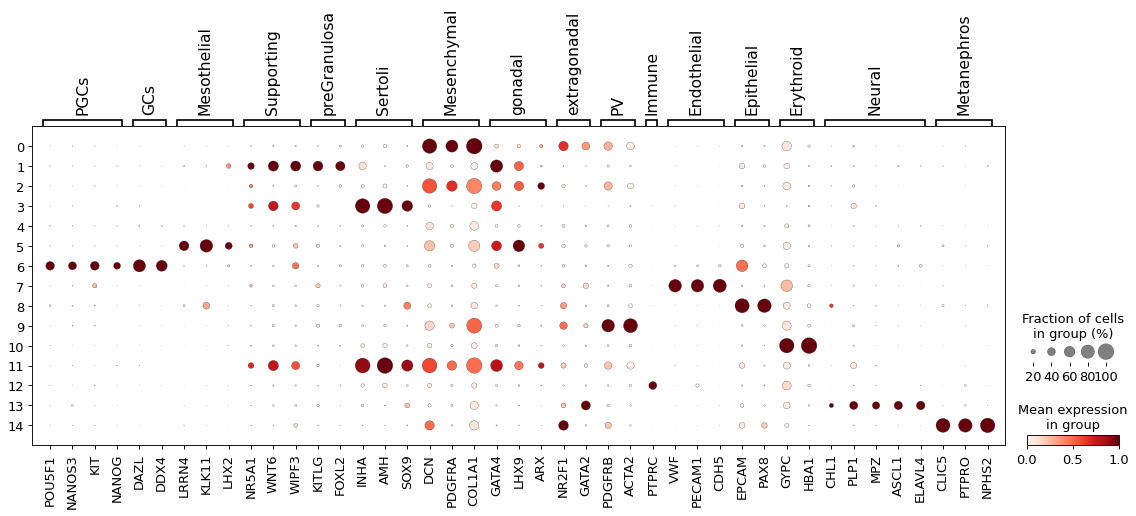

In [12]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain', use_raw=True, standard_scale = 'var', save='_louvain_markers.pdf', )

... storing 'clusters_manual' as categorical


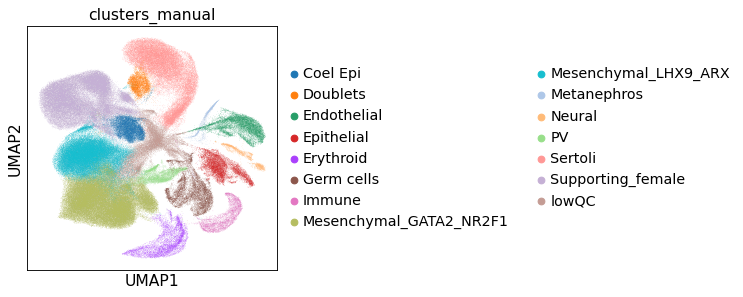

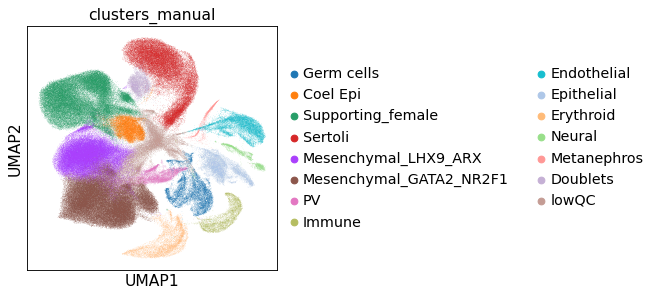

In [13]:
adata.obs['clusters_manual'] = adata.obs['louvain'].tolist()
adata.obs.at[adata.obs['clusters_manual'] == '0', 'clusters_manual'] = 'Mesenchymal_GATA2_NR2F1'
adata.obs.at[adata.obs['clusters_manual'] == '1', 'clusters_manual'] = 'Supporting_female'
adata.obs.at[adata.obs['clusters_manual'] == '2', 'clusters_manual'] = 'Mesenchymal_LHX9_ARX'
adata.obs.at[adata.obs['clusters_manual'] == '3', 'clusters_manual'] = 'Sertoli'
adata.obs.at[adata.obs['clusters_manual'] == '4', 'clusters_manual'] = 'lowQC'
adata.obs.at[adata.obs['clusters_manual'] == '5', 'clusters_manual'] = 'Coel Epi'
adata.obs.at[adata.obs['clusters_manual'] == '6', 'clusters_manual'] = 'Germ cells'
adata.obs.at[adata.obs['clusters_manual'] == '7', 'clusters_manual'] = 'Endothelial'
adata.obs.at[adata.obs['clusters_manual'] == '8', 'clusters_manual'] = 'Epithelial'
adata.obs.at[adata.obs['clusters_manual'] == '9', 'clusters_manual'] = 'PV'
adata.obs.at[adata.obs['clusters_manual'] == '10', 'clusters_manual'] = 'Erythroid'
adata.obs.at[adata.obs['clusters_manual'] == '11', 'clusters_manual'] = 'Doublets'
adata.obs.at[adata.obs['clusters_manual'] == '12', 'clusters_manual'] = 'Immune'
adata.obs.at[adata.obs['clusters_manual'] == '13', 'clusters_manual'] = 'Neural'
adata.obs.at[adata.obs['clusters_manual'] == '14', 'clusters_manual'] = 'Metanephros'
set(adata.obs['clusters_manual'])
sc.pl.umap(adata, color=['clusters_manual'])
adata.obs['clusters_manual'].cat.reorder_categories(['Germ cells', 'Coel Epi', 'Supporting_female', 'Sertoli',
                                              'Mesenchymal_LHX9_ARX', 'Mesenchymal_GATA2_NR2F1',  'PV', 'Immune', 
                                              'Endothelial', 
                                              'Epithelial',  
                                                'Erythroid',      'Neural',  'Metanephros',
                                                    'Doublets', 'lowQC'], inplace=True)

sc.pl.umap(adata, color=['clusters_manual'])

Choose the colors of the clusters a bit more consistently.

In [14]:
luz_colors = ['#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',  '#70ccbe', 
              '#7b9e99',  '#91bd80','#2d6e3d',  '#bdb380',  '#b2d19b', '#d4db81', '#ebd3c3',  '#d17c3b',
              '#dba781',  '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', 
              '#e64e74', '#d9a5c3', '#cc8fdb']

In [15]:
orig_colors = np.array(luz_colors)
new_colors = np.array(adata.uns['clusters_manual_colors'])
new_colors[[0, 1, 2, 3]] = orig_colors[[6, 5, 0, 1]]  # supporting
new_colors[[4, 5, 6, 7, 8, 9, 10, 11, 12]] = orig_colors[[7, 8, 9, 10, 11, 12, 13, 14, 15]]  # Stromal
# new_colors[[1, 7, 8, 9]] = orig_colors[[19, 23, 16, 10]]  # 
new_colors[[13, 14]] = ['#cccccc', '#f2f2f2']
# new_colors[[10, 11, 12, 13, 14]] = orig_colors[[17, 3, 9, 21,  24]]  # endothelial / orange # 18, 17, 19, 9
adata.uns['clusters_manual_colors'] = new_colors

In [16]:
sc.pl.umap(adata, color='clusters_manual',save='_clustering_nicecolors.pdf')

In [17]:
sc.pl.umap(adata[[ i not in ['Doublet','lowQC'] for i in adata.obs.clusters]], color='clusters_manual',save='_F1_main.pdf')

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Save

In [18]:
# adata.write('FCA2sex-M5-annotatedClusters.h5ad')

In [19]:
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/clustering_metadata.csv')
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv')
pd.DataFrame(adata.uns['ccgs']).to_csv(str(sc.settings.figdir)+'/cell_cycle_genes.csv')

# Plots

In [193]:
# sc.pp.scale(adata, max_value=10)

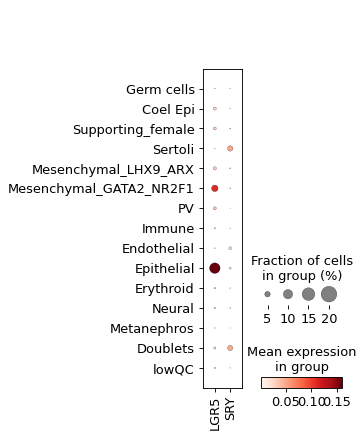

In [20]:
sc.pl.dotplot(adata, ['LGR5', 'SRY'], groupby='clusters_manual', use_raw=True)

In [23]:
sc.pl.umap(adata, color=['LGR5', 'SRY'], use_raw=False, color_map='OrRd')

In [207]:
sc.pl.dotplot(adata, marker_genes, groupby='clusters_manual', use_raw=True, save='_markers.pdf', standard_scale = 'var')

# Markers

### TF-IDF based

### Clusters

In [195]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)

In [196]:
# Binarize counts matrix (1 if expressed, 0 otherwise)
import episcanpy as epi
adata_bin = epi.pp.binarize(adata_counts, copy=True)
adata_bin.X.shape
# Compute TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(adata_bin.X.T)
adata_bin.X = tfidf.T
adata_bin.X.shape

(319081, 28230)

In [197]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata_bin, groupby='clusters_manual', use_raw=False) #, method='logreg'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:07)


normalizing by total count per cell
    finished (0:00:07): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


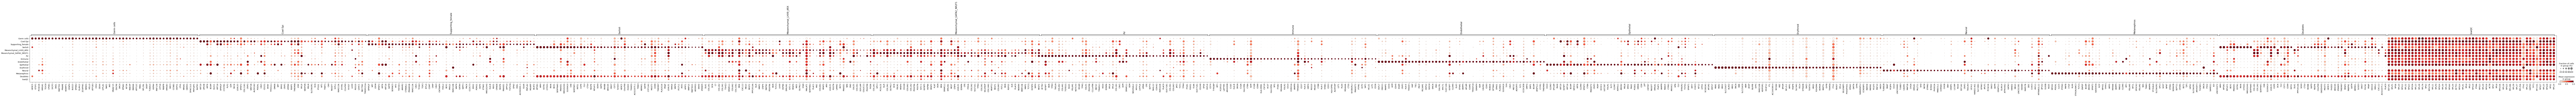

In [198]:
sc.pp.normalize_per_cell(adata_counts)
sc.pp.log1p(adata_counts)
adata_counts.uns['rank_genes_groups'] = adata_bin.uns['rank_genes_groups']
sc.pl.rank_genes_groups_dotplot(adata_counts, n_genes=50, dendrogram=False, save='_FS1_tfidf_scanpy.pdf', use_raw = False, standard_scale = 'var')

In [199]:
marker_matches = sc.tl.marker_gene_overlap(adata_bin, marker_genes, method = 'overlap_coef')
marker_matches = marker_matches.set_axis('cl_'+marker_matches.columns, axis=1, inplace=False)

<AxesSubplot:>

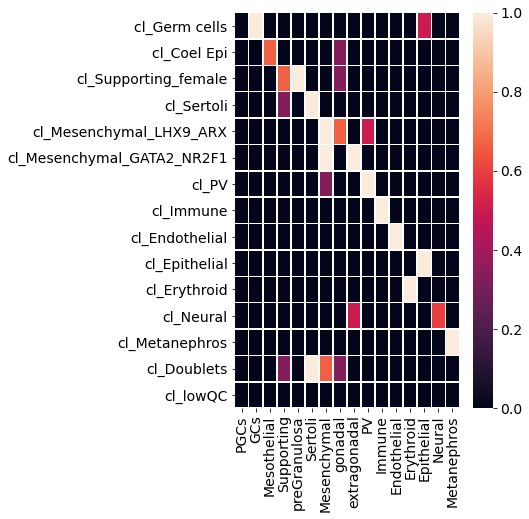

In [200]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,7))  
sns.heatmap(marker_matches.T, annot=False, xticklabels=True, yticklabels=True, linewidths=0.5, ax= ax)

# Remove doublet and plot

In [201]:
adata = adata[[ i not in 'Doublet' for i in adata.obs.clusters]]

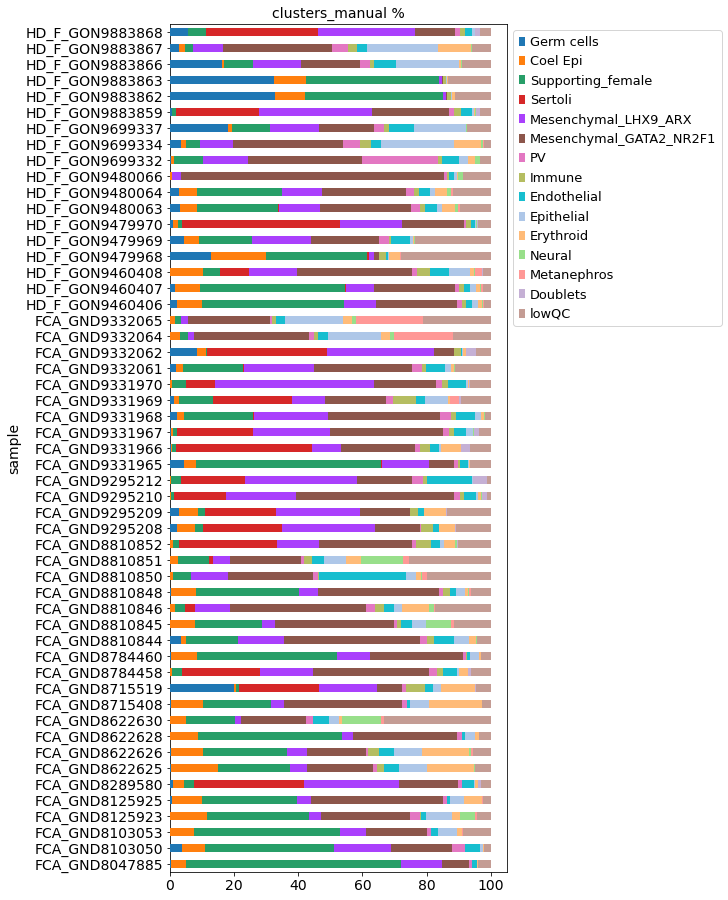

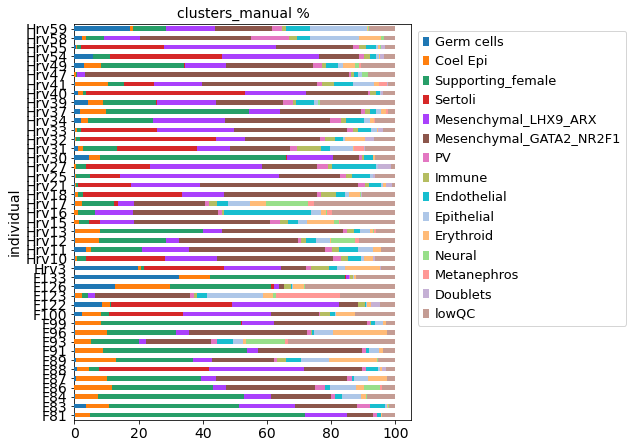

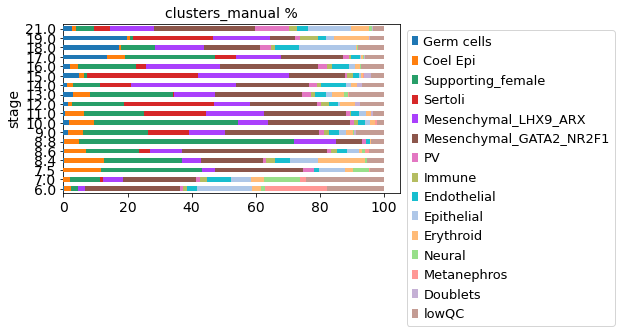

In [202]:
Barplot('clusters_manual', adata, var='sample', height=15)
Barplot('clusters_manual', adata, var='individual', height=7)
Barplot('clusters_manual', adata, var='stage', height=3)
Barplot('stage', adata, var='clusters_manual', height=4, color = ['#ff744a', '#ffa44a', '#ffcc4a', '#fff04a', '#dbd26e', '#c2c96b', '#98d16d', '#59a86e', '#119979', '#119979', '#34b6c2',  '#349cc2', '#347bc2', '#2877c7', '#185ea3', '#1e1585', '#1e1585', '#1e1585'])

In [203]:
sc.pl.dotplot(adata, marker_genes, groupby='clusters_manual', use_raw=True, save='_F1_markers.pdf', standard_scale = 'var')

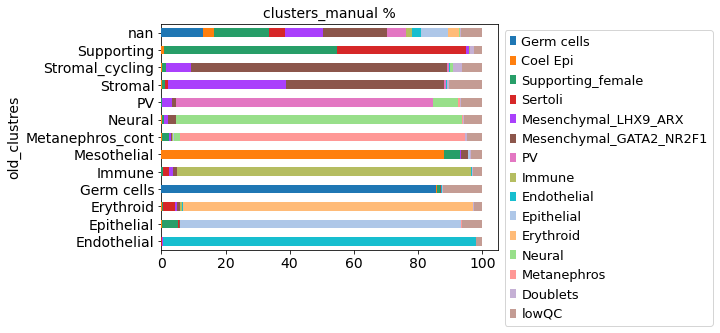

In [204]:
Barplot('clusters_manual', adata, var='old_clustres', height=4)